# **Embedding Notebook for clarity.**

### Initializing the libraries and funtions we'll be using.

In [33]:
import pandas as pd
import numpy as np
import pathlib as pl
import matplotlib.pyplot as plt
import classfolder.frameprocess as pre
from tensorflow import keras
import tensorflow as tf
import os
import time

def get_run_dir(model_path):

    rootpath = pl.Path(os.curdir)
    model_path = pl.Path(model_path) / time.strftime("%Y-%m-%d_%H-%M-%S")
    for part in model_path.parts:
        rootpath /= part
        rootpath.mkdir(exist_ok=True)
    return rootpath
def split_label(DataFrame, label='nota', label_toframe=True):
    # Separa dataframe de su designado target o label
    if label_toframe:
        data_label = DataFrame.loc[:,label].to_frame()
    else:
        data_label = DataFrame.loc[:,label]
    data = DataFrame.drop([label], axis=1)
    return data, data_label
def batching_dataset(train, target, batch_size=32, prefetch=1):
    # Recive train data y target, lo trasforma en tf.data.Dataset,
    # lo junta en tuplas(requerido por Model.fit(x) al pasar objeto Dataset),
    # agrupa la secuencia en bachas y finalmente aplica prefetch eficiencia de
    # lectura.
    # batch_size: tamaño de la bacha.
    # prefetch: cantidad de datos al que se le aplica prefetch.
    train = tf.data.Dataset.from_tensor_slices(train)
    target = tf.data.Dataset.from_tensor_slices(target)
    data = tf.data.Dataset.zip((train, target))
    data = data.batch(batch_size).prefetch(prefetch)
    return data

from sklearn.preprocessing import StandardScaler, PowerTransformer
def norm(array):
    """
    Aqui las notas pasaran a escala logaritmica. (experimental)
    """
    a = array
    # a /= 70
    # a = np.exp(a/70)
    standard = StandardScaler()
    # power = PowerTzransformer(method='yeo-johnson')
    a = np.array(a).reshape(-1, 1)
    # a = power.fit_transform(a)
    a = standard.fit_transform(a)
    a = a.reshape(-1)
    # a = np.log(a)
    return a
def sscaler_frame(data):
    mask = data['sede'] == 'colegio mayor tobalaba'
    data.loc[mask, 'nota'] = data.loc[mask, 'nota'].to_frame().apply(norm,
        axis=0, raw=True)
    data.loc[~mask, 'nota'] = data.loc[~mask, 'nota'].to_frame().apply(norm,
        axis=0, raw=True)
    return data
    
def name_toindex(names, guide=multi_label):
    """
    
    """
    if isinstance(names, list):
        in_list = []
        for name in names:
            i = guide.index(name)
            in_list.append(i)
        return in_list
    elif isinstance(names, str):
        i = guide.index(name)
        return i
    else:
        raise TypeError(f'name must be {repr(list)} or {repr(str)}')

In [34]:
path = pl.Path('D:/Proyectos/Python_proyects/MachineLearning/grade-prediction_deeplearning/Embeddings/data/archivos_mayor-cleanframe.csv')
df = pd.read_csv(path, delimiter=',', low_memory=False, index_col=0,)
df

,sede,ano,curso,asignatura,profesor-rut,semestre,alumno-rut,nota
0,colegio mayor de penalolen,2004,basica 1-a,tecnologia,8745858-k,segundo,19889609-8,67.6
1,colegio mayor de penalolen,2004,basica 1-a,idioma extranjero (ingles),11854296-7,primer,19889609-8,70.0
2,colegio mayor de penalolen,2004,basica 1-a,tecnologia,8745858-k,primer,19889609-8,67.6
3,colegio mayor de penalolen,2004,basica 1-a,educacion fisica y salud,9786497-7,segundo,19889609-8,69.0
4,colegio mayor de penalolen,2004,basica 1-a,artes visuales,8745858-k,primer,19889609-8,68.8
...,...,...,...,...,...,...,...,...
486429,colegio mayor tobalaba,2017,media 4-b,condicion fisica y motriz asociada a salud y c...,17506017-0,primer,20282314-9,70.0
486430,colegio mayor tobalaba,2017,media 4-b,condicion fisica y motriz asociada a salud y c...,17506017-0,segundo,20282314-9,70.0
486431,colegio mayor tobalaba,2017,media 4-b,biologia,13935732-9,segundo,20282314-9,50.2
486432,colegio mayor tobalaba,2017,media 4-b,idioma extranjero (ingles),12475545-k,primer,20282314-9,68.6


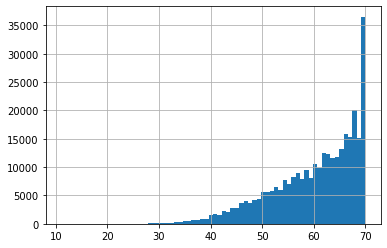

In [35]:
# names: ['sede', 'ano', 'curso', 'asignatura', 'profesor-rut',
# 'semestre', 'alumno-rut', 'nota']
subjects = df['asignatura'].unique()
subj = df['asignatura'].value_counts().index.to_numpy()
# print(subjects)
# print(subj)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
def split_data(DataFrame, split=split, prop_column='asignatura'):
    # Separa indices de dataframe en train y test data, mediante objeto
    # scikit-learn, para luego construir un generador pero retorna diferentes
    # particiones del dataframe en cada interación.
    # split: instancia de sk-learn dedicada a generar indices en dataframe
    # prop_column: columna que se utiliza como mascara para la partición,
    #    correspondiendo la proporción de los elementos en esta.
    #
    for train_index, test_index in split.split(DataFrame, DataFrame[prop_column]):
        train_frame = DataFrame.iloc[train_index].copy()
        test_frame = DataFrame.iloc[test_index].copy()
        yield train_frame, test_frame

train_data, test_data = split_data(df).__next__()
train_data, validation_data = split_data(train_data).__next__()
test_data.to_csv('D:/Proyectos/Python_proyects/MachineLearning/grade-prediction_deeplearning/Embeddings/data/test_embeddings_re0.csv', index=False)
train_data['nota'].hist(grid=True, bins=70)
plt.show()

Nota estandarizada máxima:  1.2486503906151145
Nota estandarizada mínima:  -6.131031467300419


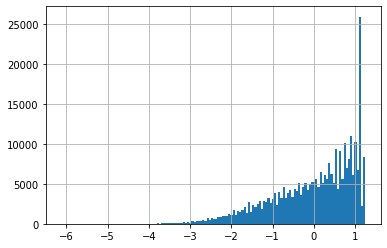

In [36]:
train_data = sscaler_frame(train_data)
validation_data = sscaler_frame(validation_data)
test_data = sscaler_frame(test_data)

print("Nota estandarizada máxima: ", train_data['nota'].max())
print("Nota estandarizada mínima: ", train_data['nota'].min())
train_data['nota'].hist(grid=True, bins=140)
plt.show()

In [37]:

# Iterator que entrega grupos, en este caso de curso por asignatura
multi_label = ['sede', 'ano', 'curso', 'semestre', 'asignatura',
    'profesor-rut']
def indexed_frame(data):
    """
    ### Indexing the student data frame:
    Sorted in a special arrange so every dataset from a groupby will be a specific course in time
    """
    data_indexed = data.set_index(multi_label, drop=True).sort_index()
    return data_indexed

train_data_indx = indexed_frame(train_data)
names = train_data_indx.index.names
print(names)
validation_data_indx = indexed_frame(validation_data)
test_data_indx = indexed_frame(test_data)#^2+145 # WHY?
train_data_indx

['sede', 'ano', 'curso', 'semestre', 'asignatura', 'profesor-rut']


alumno-rut  \
sede                       ano  curso      semestre asignatura           profesor-rut               
colegio mayor de penalolen 2004 basica 1-a primer   artes visuales       8745858-k     19838614-6   
                                                                         8745858-k     19687562-k   
                                                                         8745858-k     19688073-9   
                                                                         8745858-k     19606105-3   
                                                                         8745858-k     14729974-5   
...                                                                                           ...   
colegio mayor tobalaba     2017 media 4-b  segundo  quimica diferenciada 15716225-k    20108716-3   
                                                    termodinamica        13077848-8    20298165-8   
                                                                         13077848-8    20295895-8   
                                                                         13077848-8    20283660-7   
                                                                         13077848-8    20427803-2   

                                                                                           nota  
sede                       ano  curso      semestre asignatura           profesor-rut            
colegio mayor de penalolen 2004 basica 1-a primer   artes visuales       8745858-k     0.993512  
                                                                         8745858-k     1.141426  
                                                                         8745858-k     0.993512  
                                                                         8745858-k     0.993512  
                                                                         8745858-k     0.993512  
...                                                                                         ...  
colegio mayor tobalaba     2017 media 4-b  segundo  quimica diferenciada 15716225-k   -0.497717  
                                                    termodinamica        13077848-8   -0.148443  
                                                                         13077848-8   -0.264868  
                                                                         13077848-8   -0.148443  
                                                                         13077848-8    0.666528  

[311317 rows x 2 columns]

### Tensorflow tables from Dataframe

The idea here is to have a tensorflow optimized dataframe that can be processed by CUDA thanks to a tensorflow decorator (tf.function).

In [38]:
# Tablas de variables categoricas basado en clase de indexado tensorflow
tf_tables = pre.LookupFrame(df,
    ['asignatura', 'curso', 'ano', 'semestre', 'alumno-rut', 'profesor-rut',],
    prop_bucket=0.01,
    )

# Numero naximo de alumnos en un curso o clase de profesor en particular
maxnum = 0
minnum = 20
numdata = 0
for index, data in train_data_indx.groupby(level=names).__iter__():
    curr_len = data.shape[0]
    maxnum = np.amax([curr_len, maxnum])
    minnum = np.amin([curr_len, minnum])
    numdata+=1
maxnum += 5
print("\nNumero total de datasets: ", numdata)
print("\nCurso con la menor cantidad: ", minnum)
print()


Numero total de datasets:  20068

Curso con la menor cantidad:  1



In [39]:
train_groups = train_data_indx.groupby(level=names)

def train_data_gen(groups=train_groups):
    """
    From an indexed Dataframe,  
    """
    while True:
        for index, frame in iter(groups):
            matrix = frame.to_numpy()
            students = matrix[:,0]
            grades = matrix[:,1].astype(np.float64)
            index = np.array([str(i) for i in index])
            yield (index, students), grades


train_dataset = tf.data.Dataset.from_generator(train_data_gen,
    output_types=((tf.string, tf.string), tf.float64),
    output_shapes=((tf.TensorShape([len(multi_label)]),
        tf.TensorShape([None])),
        tf.TensorShape([None])),
)

In [40]:
match = name_toindex(['curso', 'semestre', 'profesor-rut'])
@tf.function
def transform_data(X, y):
    """
    ### Tensorflow enhanced function:
    Transform the grouby dataset (by courses) in a way that is fit for the tensorflow model.
    """
    global match
    index, _students = X
    grades = y
    students = tf_tables['alumno-rut'].lookup(_students)

    # Busca el index que le corresponde al nombre en la lista de
    # Multilabel
    level = tf_tables['curso'].lookup(index[match[0]])
    level = tf.reshape(level, [1])
    semester = tf_tables['semestre'].lookup(index[match[1]])
    semester = tf.reshape(semester, [1])
    profesor =  tf_tables['profesor-rut'].lookup(index[match[2]])
    profesor = tf.reshape(profesor, [1])

    _subjects = tf.constant(subjects, dtype=tf.string)
    all_subjects = tf_tables['asignatura'].lookup(_subjects)
    all_subjects = tf.reshape(all_subjects, [len(subjects)])

    return {'input_students': students,
        'input_level': level,
        'input_semester': semester,
        'input_profesor': profesor,
        'input_subjects': all_subjects,
        }, {'output_grades': grades}
buffer = numdata + 1
train_dataset = train_dataset.shuffle(buffer)
train_dataset = train_dataset.map(lambda x, y: transform_data(x, y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    # deterministic=False
    )

In [41]:
batch_size = 64
steps_per_epoch = numdata//batch_size
def batching(dataset):
    dataset = dataset.padded_batch(batch_size,
        padded_shapes=({'input_students': maxnum,
            'input_level': 1,
            'input_semester': 1,
            'input_profesor': 1,
            'input_subjects': len(subjects),
            }, {'output_grades': maxnum}),
        # padded_values=0,
        ).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = batching(train_dataset)

### **Model**

In [42]:
# Dimension del embedding para todos los inputs
embed_dim = 2 ** 5 #8 #7 cambio realizado el 20-09-09
# Embedding del un curso con un profesor en particular
total_student = tf_tables.get_lenght('alumno-rut')
input_students = keras.layers.Input(shape=[maxnum],
    batch_size=batch_size,
    name="input_students",
    # ragged=True,
    )
students = keras.layers.Embedding(input_dim=total_student,
    output_dim=embed_dim,
    mask_zero=True,
    embeddings_initializer=keras.initializers.GlorotNormal(),
    name="alumno-rut",
    )
students_tensor = students(input_students)
noise = keras.layers.GaussianNoise(stddev=0.8)
students_tensor = noise(students_tensor)

# Embedding del nivel conjunto con el semestre, será una multiplicación de estos dos.
# Como los diccionarios de tensorflow parten de 0, se suma 1 al tensor
# para asegurar que dos tuplas; (nivel, semestre), no repita sus indices
total_levels = tf_tables.get_lenght('ano')
num_semesters = tf_tables.get_lenght('semestre')
input_level = keras.layers.Input(shape=[1],
    name="input_level")
input_semester = keras.layers.Input(shape=[1],
    name="input_semester")
combined = input_semester*input_level

semester = keras.layers.Embedding(input_dim=total_levels*num_semesters,
    output_dim=embed_dim,
    mask_zero=True,
    embeddings_initializer=keras.initializers.GlorotNormal(),
    name="embed_level-semester",
    )
semester_vec = semester(combined)

# Suma del embedding correspondientes a los alumnos y "semestre", respecticamente
# Notar que semester_vec es la suma del embed original semestre junto con embed
# nivel.
course_tensor =  students_tensor + semester_vec

# Embedding de todas las asignaturas existentes
total_subjects = tf_tables.get_lenght('asignatura')
input_subjects = keras.Input(shape=[len(subjects)],
    name="input_subjects")
embed_subjects = keras.layers.Embedding(input_dim=total_subjects,
    output_dim=embed_dim,
    mask_zero=True,
    embeddings_initializer=keras.initializers.GlorotNormal(),
    name="asignatura",
    )
subjects_tensor = embed_subjects(input_subjects)

# Vector de el profesor del curso
total_profesors = tf_tables.get_lenght('profesor-rut')
input_profesor = keras.Input(shape=[1],
    name="input_profesor"
    )
profesors = keras.layers.Embedding(input_dim=total_profesors,
    output_dim=embed_dim,
    mask_zero=True,
    embeddings_initializer=keras.initializers.GlorotNormal(),
    name="profesor-rut",
    )
profesor_vec = profesors(input_profesor)
noise2 = keras.layers.GaussianNoise(stddev=0.4)
profesor_vec = noise2(profesor_vec)

# Self-Atencion de cada curso, es decir de cada "alumno-vector" con todos los
# demas
# """fuera self-attention"""
a1 = keras.layers.Attention(use_scale=True)([course_tensor, course_tensor])
# a1 = course_tensor

# Nuevamente Atencion por parte de cada "atencion del alumno-vector" hacia
# todas las asignaturas existentes
a2 = keras.layers.Attention(use_scale=True)([a1, subjects_tensor])

# Luego de consegir el vector de atención que le dedican los alumnos del curso,
# este se proyecta con el vector del para medir su influecia, dando la nota
# especifica del alumno en la asignatura correspondiente
output_grades = keras.layers.Dot(axes=2, name="output_grades")([a2, profesor_vec])

### Model engine and Callbacks

In [43]:
encoder = keras.Model(inputs=[input_students,
        input_level,
        input_semester,
        input_subjects,
        input_profesor
        ],
    outputs=[output_grades])
encoder.summary()

run_logdir = get_run_dir("pCM_logs/clean_subjects/glorot/5bit-dim/noise_s08-p04/subj_focus.h5")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_logdir,
    write_images=True,
    histogram_freq=5,
    # embeddings_freq=5,
    )
early_cb = keras.callbacks.EarlyStopping(patience=35,
    restore_best_weights=True)
def best_lr(history):
    lrs = np.array(history.history["lr"])
    losses = np.array(history.history["loss"])
    dloss = losses[1:] - losses[:-1]
    min_index = np.argmin(dloss)
    return lrs[min_index]
init_lr = 1e-10
final_lr = 1e-2
total_epochs = 100
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: init_lr*(final_lr/init_lr)**(epoch/total_epochs)
)

encoder.compile(loss=tf.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(lr=0.00012),
    metrics=['mean_absolute_error'],
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_students (InputLayer)    [(64, 50)]           0           []                               
                                                                                                  
 input_semester (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 input_level (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 alumno-rut (Embedding)         (64, 50, 32)         191904      ['input_students[0][0]']         
                                                                                              

d:\Proyectos\Python_proyects\Algos-y-Estructuras\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Test and Validation data preparation

In [44]:

test_groups = test_data_indx.groupby(level=names)
def test_data_gen(groups=test_groups):
        for index, frame in iter(groups):
            matrix = frame.to_numpy()
            students = matrix[:,0]
            grades = matrix[:,1].astype(np.float64)
            index = np.array([str(i) for i in index])
            yield (index, students), grades
test_dataset = tf.data.Dataset.from_generator(test_data_gen,
    output_types=((tf.string, tf.string), tf.float64),
    output_shapes=((tf.TensorShape([len(multi_label)]),
        tf.TensorShape([None])),
        tf.TensorShape([None])),
    )
test_dataset = test_dataset.map(map_func=lambda x, y: transform_data(x, y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    # deterministic=False
    )
test_dataset = batching(test_dataset)
test_steps = int((numdata*0.2/0.8**2)/batch_size)
loss_untrained, metrics_untrained = encoder.evaluate(test_dataset, steps=test_steps)

val_groups = validation_data_indx.groupby(level=names)
def val_data_gen(groups=val_groups):
    while True:
        for index, frame in iter(groups):
            matrix = frame.to_numpy()
            students = matrix[:,0]
            grades = matrix[:,1].astype(np.float64)
            index = np.array([str(i) for i in index])
            yield (index, students), grades
val_dataset = tf.data.Dataset.from_generator(val_data_gen,
    output_types=((tf.string, tf.string), tf.float64),
    output_shapes=((tf.TensorShape([len(multi_label)]),
        tf.TensorShape([None])),
        tf.TensorShape([None])),
    )
val_dataset = val_dataset.map(lambda x, y: transform_data(x, y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    # deterministic=False
    )
val_dataset = batching(val_dataset)
val_steps = int((numdata*0.2/0.8)/batch_size)

history= encoder.fit(train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    callbacks=[tensorboard_callback, early_cb, lr_schedule],
    use_multiprocessing=True,
    workers=tf.data.experimental.AUTOTUNE,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps
    )

best_lr(history)

97/97 [==============================] - 18s 84ms/step - loss: 0.1040 - mean_absolute_error: 0.0892
Epoch 1/100
313/313 [==============================] - 53s 90ms/step - loss: 0.3207 - mean_absolute_error: 0.3014 - val_loss: 0.0844 - val_mean_absolute_error: 0.0723 - lr: 1.0000e-10
Epoch 2/100
313/313 [==============================] - 21s 68ms/step - loss: 0.3157 - mean_absolute_error: 0.2983 - val_loss: 0.0844 - val_mean_absolute_error: 0.0723 - lr: 1.2023e-10
Epoch 3/100
313/313 [==============================] - 29s 94ms/step - loss: 0.3170 - mean_absolute_error: 0.2993 - val_loss: 0.0844 - val_mean_absolute_error: 0.0723 - lr: 1.4454e-10
Epoch 4/100
313/313 [==============================] - 29s 93ms/step - loss: 0.3152 - mean_absolute_error: 0.2992 - val_loss: 0.0844 - val_mean_absolute_error: 0.0723 - lr: 1.7378e-10
Epoch 5/100
313/313 [==============================] - 27s 88ms/step - loss: 0.3183 - mean_absolute_error: 0.2992 - val_loss: 0.0844 - val_mean_absolute_error: 0.07

0.00017378008

### Tensorboard

97/97 [==============================] - 7s 72ms/step - loss: 0.0510 - mean_absolute_error: 0.0664


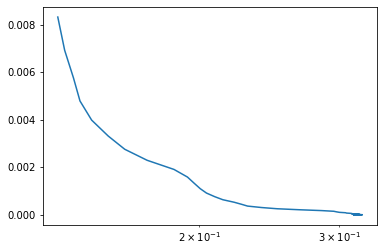

In [45]:
plt.semilogx(history.history["loss"], history.history["lr"])
run_savedir = get_run_dir("records/clean_subjects/glorot/5bit-dim/noise_s08-p04")
encoder.save(run_savedir.as_posix()+'/subj_focus.h5')

loss_trained, metrics_trained = encoder.evaluate(test_dataset, steps=test_steps)